# Telco Churn Modelling

The notebook aims to find the model that is best able to determine which customers are going to churn from the platform. We will be considering the following models:

* Logistic Regression
* Random Forest Classifier
* Gradient Boosting Classifier
* Nearest Centroid ( Baseline Model)
* Nearest Component Analysis + K-Nearest Neighbours


## Evaluation Metric : F1 Score
The models' performances will be evaluated on their __F1 Score__, which is the harmonic mean of the __precision__ and __recall__.

__Recall__ is important as we want to __identify as many potential churn customers as possible__, in order to target them with promotions to entice them to remain with the Telco.

However, __precision__ is also important as we want to minimise our advertising / promotion expenditure and avoid sending promotions to customers who are unlikely to churn. 

Therefore, we believe that the F1 score is the appropriate metric as it balances the need to improve customer retention while also factoring in the costs of employing advertising and promotions.

#### Importing Libraries

In [52]:
# Standard Tools
from scipy import stats
import pandas as pd
import numpy as np
import warnings
import pickle
import sys 
# sys.path.insert(0, '/home/yeokoso/Documents/ml_scripts') # Laptop Path
sys.path.insert(0, 'C:\\Users\\Joshua\\Documents\\DS_Projects\ml_scripts') # PC path
warnings.filterwarnings('ignore')

# Custom Functions
import modelling_functions as modf

# Machine Learning
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.svm import LinearSVC, SVC

# Sampling Tools
from imblearn.over_sampling import SMOTE, ADASYN, KMeansSMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline

# Visualisation
from yellowbrick.classifier import DiscriminationThreshold
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_formate = 'retina'
plt.style.use('fivethirtyeight')

# Random State
SEED = 8888

#### Loading our Data

In [53]:
with open('cleaned_dataset_all_levels.pickle', 'rb') as f:
    df = pickle.load(f)

In [54]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,InternetService_DSL,InternetService_Fiber_optic,InternetService_No,Contract_Month_to_month,Contract_One_year,Contract_Two_year,PaymentMethod_Bank_Transfer,PaymentMethod_Credit_Card,PaymentMethod_E_Check,PaymentMethod_Check
0,0,0,1,0,1,0,0,1,0,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,1,0,1,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,1,0,0,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,1,0,1,1,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


#### Splitting Data into Training and Testing Datasets

In [55]:
X = df.drop('Churn', axis = 1)
y = df.Churn

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

In [57]:
# Defining our cross validation method
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [58]:
# Kwargs for cross_validate method
cv_kwargs = {
    'scoring' : 'f1',
    'cv' : skf,
    'n_jobs' : -1,
    'return_train_score' : True,
    'verbose' : False,
    'return_estimator' : True
}

## Baseline Model : Nearest Centroid Classifier
The Nearest Centroid Classifier is a simple algorithm that represents each class by the __centroid of its members__, similar to the label updating phase of the K-Means algorithm. Furthermore, there are __no parameters to choose__ from, making it a __good baseline classifier__.

Cross Validation Results Summary
Avg Training score 	 0.611119
Avg Testing score 	 0.609757

Avg Fitting Time 	 0.0113s
Avg Scoring Time 	 0.0029s


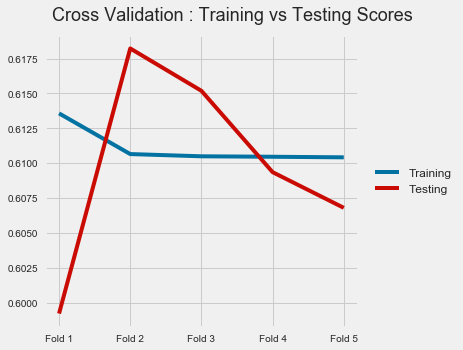

In [59]:
ncc_pipe = Pipeline(steps=[
    ('Standardise', StandardScaler()),
    ('NearestCentroid', NearestCentroid())
])

ncc_cv_results = modf.cross_validation_summary(ncc_pipe, X_train, y_train, cv_kwargs)

Our baseline model has an approximate 80% recall. We will save the estimator that performed the best during cross validation and test it on the holdout dataset.

Holdout Dataset Classification Report for Nearest Centroid
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1033
           1       0.49      0.78      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407




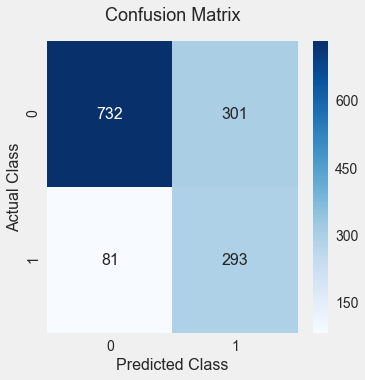

In [60]:
ncc_model = modf.get_best_estimator(ncc_cv_results, greater_is_better=True)

ncc_y_pred = modf.holdout_evaluation(ncc_model, X_train, y_train, X_test, y_test,
                                     model_name='Nearest Centroid', threshold=0.5)

From the results above, the nearest centroid model has about 78% recall. We can also notice that the model seems to be over predicting the positive class, given its low precision of 49%. 

We will save the performance of our baseline and compare the results to other classification algorithms.

In [62]:
ncc_results = modf.classification_scores(y_test, ncc_y_pred, model_name='NearestCentroid')
ncc_results

,Model,Accuracy,ROC_AUC,Precision,Recall,F1
0,NearestCentroid,0.7285,0.746,0.4933,0.7834,0.6054


In [63]:
# Creating a results dataframe to compare models
model_results = ncc_results.copy(deep=True)

### Oversampling Minority Class
Our dataset is imbalanced with only around 25% of observations being Churn customers. As our dataset is relatively small at 7000 observations, we will attempt some over sampling techniques and observe if they improve our modelling results.

Over Sampling Methods:
* Random Over Sampling
* Synthetic Minority Over Sampling (SMOTE)
* Adaptive Synthetic Over Sampling (ADASYN)

#### Creating Our Resampling Pipelines

In [64]:
ros = RandomOverSampler(random_state=SEED)
smote = SMOTE(random_state=SEED)
adasyn = ADASYN(random_state=SEED)

ros_ncc_pipe = Pipeline(steps=[
    ('RandomOverSampler', ros),
    ('Standardise', StandardScaler()),
    ('NearestCentroid', NearestCentroid())
])

smote_ncc_pipe = Pipeline(steps=[
    ('SMOTE', smote),
    ('Standardise', StandardScaler()),
    ('NearestCentroid', NearestCentroid())
])

adasyn_ncc_pipe = Pipeline(steps=[
    ('ADASYN', adasyn),
    ('Standardise', StandardScaler()),
    ('NearestCentroid', NearestCentroid())
])

ncc_resampled_pipes = [ros_ncc_pipe, smote_ncc_pipe, adasyn_ncc_pipe]

#### Comparing Resampling Results

In [65]:
base_model_name = 'NearestCentroid'

for i, clf in enumerate(ncc_resampled_pipes):
    if i == 0:
        model_name = 'ROS_' + base_model_name
    if i == 1:
        model_name = 'SMOTE_' + base_model_name
    if i == 2:
        model_name = 'ADASYN_' + base_model_name
        
    cv_results = cross_validate(clf, X_train, y_train, **cv_kwargs)
    best_clf = modf.get_best_estimator(cv_results)
    y_pred = best_clf.predict(X_test)
    
    result = modf.classification_scores(y_test, y_pred, model_name)
    model_results = model_results.append(result, ignore_index=True)

In [66]:
model_results

,Model,Accuracy,ROC_AUC,Precision,Recall,F1
0,NearestCentroid,0.7285,0.7460,0.4933,0.7834,0.6054
1,ROS_NearestCentroid,0.7242,0.7482,0.4886,0.7995,0.6065
2,SMOTE_NearestCentroid,0.7292,0.7482,0.4941,0.7888,0.6076
3,ADASYN_NearestCentroid,0.7079,0.7371,0.4709,0.7995,0.5927


After applying resampling methods, there is a small improvement over the baseline Nearest Centroid model. Both SMOTE and ROS have a greater F1 score than baseline, with SMOTE having the highest. 

SMOTE's improvement in F1 is more balanced, with improvements to both precision and recall over the baseline. However, if churn costs turn out to be more costly than advertisments, the ROS model may be prefered as it has the highest recall of the models, while offering an F1 similar to the SMOTE.

We will drop the Baseline and ADASYN models from the comparison table.

In [68]:
# Dropping models
model_results = model_results.drop([1, 3]).reset_index(drop=True)

### Nearest Component Analysis and Nearest Neighbours

In [70]:
# Creating dict of kwargs for GridSearchCV
gs_kwargs = dict((k, cv_kwargs[k]) for k in cv_kwargs if k != 'return_estimator')
gs_kwargs

{'scoring': 'f1',
 'cv': StratifiedKFold(n_splits=5, random_state=8888, shuffle=True),
 'n_jobs': -1,
 'return_train_score': True,
 'verbose': False}

In [71]:
knn_pipe = Pipeline(steps=[
    ('Standardise', StandardScaler()),
    ('KNN', KNeighborsClassifier())
])

knn_param_grid = {
    'KNN__n_neighbors' : np.arange(2, 16, step=1),
}

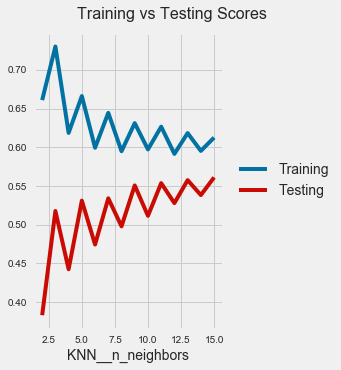

In [72]:
modf.param_tuning_plots(knn_pipe, knn_param_grid, X_train, y_train, gs_kwargs, n_cols=1, figsize=(5,5))

It appears that smaller number of neighbours produce more robust results. We will perform a grid search again on a smaller set of parameters to find the optimal hyper paramters before evaluating the results.

In [73]:
# Updated param gird with more hyper parameters
knn_param_grid = {
    'KNN__n_neighbors' : np.arange(2, 5, step=1),
    'KNN__weights' : ['uniform', 'distance'],
    'KNN__algorithm' : ['ball_tree', 'kd_tree'],
    'KNN__metric' : ['euclidean', 'manhattan'],
    'KNN__n_jobs' : [-1]
}

In [74]:
knn_gscv = GridSearchCV(knn_pipe, knn_param_grid, **gs_kwargs)
knn_gscv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=8888, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('Standardise',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('KNN',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weig

In [85]:
# Saving the best kwargs for KNN
knn_kwargs = dict((k[5:], knn_gscv.best_params_[k]) for k in knn_gscv.best_params_)
knn_kwargs

{'algorithm': 'ball_tree',
 'metric': 'euclidean',
 'n_jobs': -1,
 'n_neighbors': 3,
 'weights': 'uniform'}

Holdout Dataset Classification Report for Nearest Neighbours
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1033
           1       0.53      0.50      0.52       374

    accuracy                           0.75      1407
   macro avg       0.68      0.67      0.68      1407
weighted avg       0.75      0.75      0.75      1407




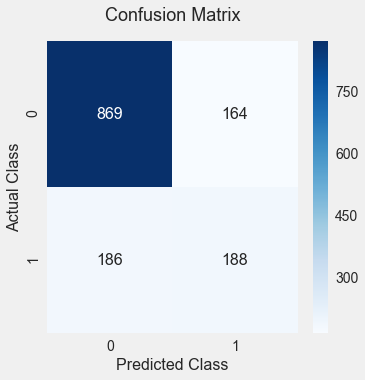

In [76]:
# Saving best estimator during GridSearch and evaluating on holdout data
knn_model = knn_gscv.best_estimator_
knn_y_pred = modf.holdout_evaluation(knn_model, X_train, y_train, X_test, y_test,
                                     model_name='Nearest Neighbours', threshold=0.5)

It appears the KNN model is not good at detecting the positive class (churn customers) with low recall and precision. 

Let's take a look at the precision recall curve and check if there is better threshold we can set for the KNN model to improve its performance.

In [77]:
def discrimination_threshold_plot(model, X_train, y_train, cv, random_state, n_trails=5, exclude='queue_rate', figsize=(6,6), ax=None, title=' Discrimination Threshold Plot'):
    ''' Function to plot the discrimination threshold, showing how precision and recall changes.
    
    Arguments:
        model : scikit learn estimator object
            Must be a classifier with a predict_proba method
        cv : int or callable 
            Number of cross validations or K-folds cross validation object
        n_trails : int, default = 5
            Number of times to shuffle and split the dataset to account for noise in the threshold metrics curves.
        exclude : str or list, default = 'queue_rate'
            Specify metrcis to omit from the graph.
            Can be 'precision', 'recall', 'queue_rate' and 'fscore'
    '''
    visualiser = DiscriminationThreshold(model, ax=ax, n_trails=n_trails, cv=cv,
                                         random_state=random_state, title=title)
    visualiser.fit(X_train, y_train)
    
    if ax == None:
        ax = plt.gca()
        
    fig = plt.figure(figsize=figsize)
    ax.set_title(title, size=18, y=1.05)
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.rcParams["legend.fontsize"] = 14
    visualiser.show();

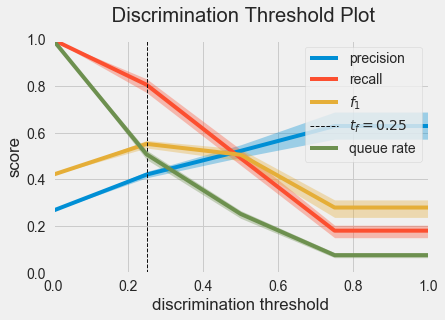

<Figure size 432x432 with 0 Axes>

In [78]:
discrimination_threshold_plot(knn_model, X_train, y_train, cv=skf, random_state=SEED)

From the diagram above, we can see that adjusting the threshold to 0.25 would provide us the optimal balance between recall and precision. We will change the prediction threshold and evaluate the KNN model's performance again.

Holdout Dataset Classification Report for Nearest Neighbours
              precision    recall  f1-score   support

           0       0.89      0.59      0.71      1033
           1       0.41      0.80      0.54       374

    accuracy                           0.64      1407
   macro avg       0.65      0.69      0.63      1407
weighted avg       0.76      0.64      0.66      1407




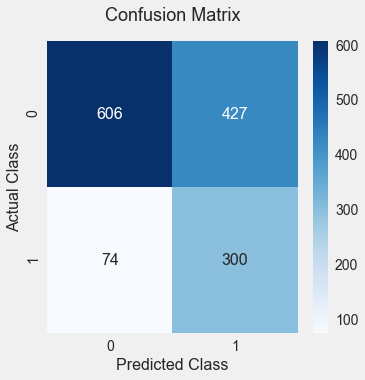

In [79]:
knn_y_pred = modf.holdout_evaluation(knn_model, X_train, y_train, X_test, y_test,
                                     model_name='Nearest Neighbours', threshold=0.25)

As we decreases the threshold, the model has increased sensitivity, resulting in an increase in recall to 80%, however, it is mainly just predicting more of the positive class, which has resulted in a marked increase in the number of false positives.

Overall, the initial KNN model is more balanced but offers poorer performance than the baseline model.

In [80]:
knn_results = modf.classification_scores(y_test, knn_y_pred, model_name='NearestNeighbour')
model_results = model_results.append(knn_results, ignore_index=True)
model_results

,Model,Accuracy,ROC_AUC,Precision,Recall,F1
0,NearestCentroid,0.7285,0.7460,0.4933,0.7834,0.6054
1,SMOTE_NearestCentroid,0.7292,0.7482,0.4941,0.7888,0.6076
2,NearestNeighbour,0.6439,0.6944,0.4127,0.8021,0.5450


### Resampling KNN

Similar to our baseline model, we will attempt resampling and investigate if there is any improvements for the KNN model.

In [91]:
ros_knn_pipe = Pipeline(steps=[
    ('RandomOverSampler', ros),
    ('Standardise', StandardScaler()),
    ('KNN', KNeighborsClassifier(**knn_kwargs))
])

smote_knn_pipe = Pipeline(steps=[
    ('SMOTE', smote),
    ('Standardise', StandardScaler()),
    ('KNN', KNeighborsClassifier(**knn_kwargs))
])

adasyn_knn_pipe = Pipeline(steps=[
    ('ADASYN', adasyn),
    ('Standardise', StandardScaler()),
    ('KNN', KNeighborsClassifier(**knn_kwargs))
])

knn_resampled_pipes = [ros_knn_pipe, smote_knn_pipe, adasyn_knn_pipe]

In [92]:
base_model_name = 'NearestNeighbour'

for i, clf in enumerate(knn_resampled_pipes):
    if i == 0:
        model_name = 'ROS_' + base_model_name
    if i == 1:
        model_name = 'SMOTE_' + base_model_name
    if i == 2:
        model_name = 'ADASYN_' + base_model_name
        
    cv_results = cross_validate(clf, X_train, y_train, **cv_kwargs)
    best_clf = modf.get_best_estimator(cv_results)
    y_pred = best_clf.predict(X_test)
    
    result = modf.classification_scores(y_test, y_pred, model_name)
    model_results = model_results.append(result, ignore_index=True)

In [93]:
model_results

,Model,Accuracy,ROC_AUC,Precision,Recall,F1
0,NearestCentroid,0.7285,0.7460,0.4933,0.7834,0.6054
1,SMOTE_NearestCentroid,0.7292,0.7482,0.4941,0.7888,0.6076
2,NearestNeighbour,0.6439,0.6944,0.4127,0.8021,0.5450
3,ROS_NearestNeighbour,0.6851,0.6781,0.4389,0.6631,0.5282
4,SMOTE_NearestNeighbour,0.7129,0.6893,0.4705,0.6390,0.5420
5,ADASYN_NearestNeighbour,0.6986,0.6830,0.4534,0.6497,0.5341


From the results table above, we see that the resampling methods all have greater precision than the original KNN model, but the decrease in recall far outweights any precision gains.

Therefore, the resampling does not seem to have had a beneficial effect on the KNN model.

In [94]:
model_results = model_results.drop([3,4,5])

## Logistic Regression

#### Hyper Parameter Tuning

In [96]:
# Creating logisitic regression model and parameter grid to iterate over
logreg_kwargs = {
    'class_weight' : 'balanced',
    'penalty' : 'l2',
    'solver' : 'lbfgs',
    'max_iter' : 1000,
    'n_jobs' : -1,
    'random_state' : SEED
}

logreg_model = LogisticRegression(**logreg_kwargs)

logreg_param_grid = {
    'C' : np.logspace(-4, 1, 6)
}

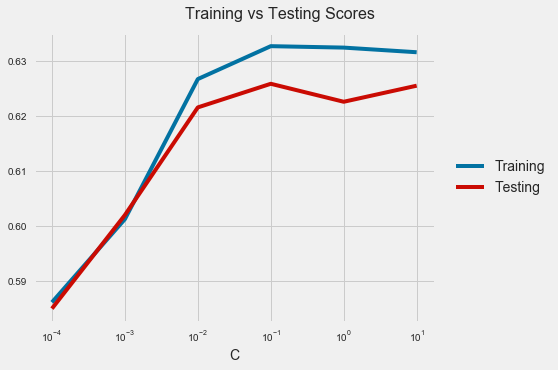

In [97]:
modf.param_tuning_plots(logreg_model, logreg_param_grid, X_train, y_train, gs_kwargs,
                        n_cols=1, x_axis_log_scale=True, figsize=(8,5))

From the figure above, we observe that the optimal value of the C (invese lambda) hyper parameter should be between 0.01 to 1. We will now perform a grid search to determine the optimal value.

In [98]:
logreg_param_grid = {
    'C' : np.arange(0.01, 1.01, step=0.01)
}

In [99]:
logreg_gscv = GridSearchCV(logreg_model, logreg_param_grid, **gs_kwargs)
logreg_gscv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=8937, shuffle=True),
             error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=-1, penalty='l2',
                                          random_state=8888, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='dep...
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
  

In [100]:
# Updating our logisitc regression kwargs
logreg_kwargs['C'] = logreg_gscv.best_params_['C']
logreg_kwargs

{'class_weight': 'balanced',
 'penalty': 'l2',
 'solver': 'lbfgs',
 'max_iter': 1000,
 'n_jobs': -1,
 'random_state': 8888,
 'C': 0.11}

Holdout Dataset Classification Report for Logistic Regression
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1033
           1       0.51      0.81      0.63       374

    accuracy                           0.74      1407
   macro avg       0.71      0.76      0.71      1407
weighted avg       0.81      0.74      0.76      1407




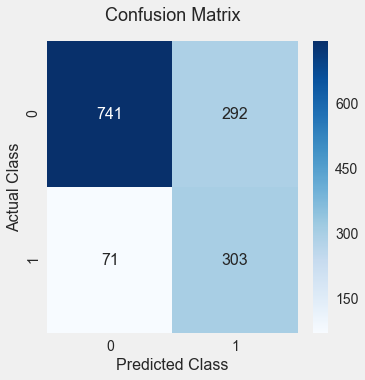

In [101]:
# Saving the best estimator during GridSearch and getting evaluating on holdout data
logreg_model = logreg_gscv.best_estimator_
logreg_y_pred = modf.holdout_evaluation(logreg_model, X_train, y_train, X_test, y_test,
                                        model_name='Logistic Regression', threshold=0.5)

In [102]:
logreg_results = modf.classification_scores(y_test, logreg_y_pred, model_name='LogisticRegression')
model_results = model_results.append(logreg_results, ignore_index=True)
model_results

,Model,Accuracy,ROC_AUC,Precision,Recall,F1
0,NearestCentroid,0.7285,0.7460,0.4933,0.7834,0.6054
1,SMOTE_NearestCentroid,0.7292,0.7482,0.4941,0.7888,0.6076
2,NearestNeighbour,0.6439,0.6944,0.4127,0.8021,0.5450
3,LogisticRegression,0.7420,0.7637,0.5092,0.8102,0.6254


The logistic regression has the best performance so far, with the highest recall and precision among all the models so far.

We will try the same over sampling technniques to see if there are any improvements to the logistic model.

In [103]:
ros_logreg_pipe = Pipeline(steps=[
    ('RandomOverSampler', ros),
    ('LogisticRegression', LogisticRegression(**logreg_kwargs))
])

smote_logreg_pipe = Pipeline(steps=[
    ('SMOTE', smote),
    ('LogisticRegression', LogisticRegression(**logreg_kwargs))
])

adasyn_logreg_pipe = Pipeline(steps=[
    ('ADASYN', adasyn),
    ('LogisticRegression', LogisticRegression(**logreg_kwargs))
])

logreg_resampled_pipes = [ros_logreg_pipe, smote_logreg_pipe, adasyn_logreg_pipe]

In [107]:
base_model_name = 'LogisticRegression'

for i, clf in enumerate(logreg_resampled_pipes):
    if i == 0:
        model_name = 'ROS_' + base_model_name
    if i == 1:
        model_name = 'SMOTE_' + base_model_name
    if i == 2:
        model_name = 'ADASYN_' + base_model_name
        
    cv_results = cross_validate(clf, X_train, y_train, **cv_kwargs)
    best_clf = modf.get_best_estimator(cv_results)
    y_pred = best_clf.predict(X_test)
    
    result = modf.classification_scores(y_test, y_pred, model_name)
    model_results = model_results.append(result, ignore_index=True)

In [108]:
model_results

,Model,Accuracy,ROC_AUC,Precision,Recall,F1
0,NearestCentroid,0.7285,0.7460,0.4933,0.7834,0.6054
1,SMOTE_NearestCentroid,0.7292,0.7482,0.4941,0.7888,0.6076
2,NearestNeighbour,0.6439,0.6944,0.4127,0.8021,0.5450
3,LogisticRegression,0.7420,0.7637,0.5092,0.8102,0.6254
4,ROS_LogisticRegression,0.7363,0.7582,0.5025,0.8048,0.6187
5,SMOTE_LogisticRegression,0.7392,0.7584,0.5059,0.7995,0.6197
6,ADASYN_LogisticRegression,0.7143,0.7508,0.4784,0.8289,0.6067


Similar to KNN, the resampling techniques do not improve the performance of the logistic model in terms of F1 score. 

However, if recall is more important than precision, resampling by ADASYN before fitting the model may be the better choice. ADASYN resampling has improved the recall by almost 2% at the expense of a drop in precision by about 3% over the baseline logistic model.

In [112]:
model_results = model_results.drop([4,5]).reset_index(drop=True)

## Random Forest Classifier

#### Pre-tuned Random Forest
There are much more hyper parameters to tune in random forests. We want to compare the results of an untuned model to one that has the optimal parameters.

In [114]:
# Baseline random forest kwargs before tuning
rforest_kwargs = {
    'n_estimators' : 100,
    'criterion' : 'gini',
    'class_weight' : 'balanced',
    'bootstrap' : True,
    'n_jobs' : -1,
    'random_state' : SEED,
}
baseline_rforest = RandomForestClassifier(**rforest_kwargs)

Holdout Dataset Classification Report for Random Forest
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.49      0.56       374

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407




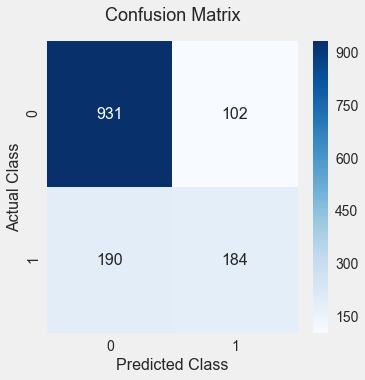

In [115]:
# Checking the performance of an untuned random forest
baseline_rforest_y_pred = modf.holdout_evaluation(baseline_rforest, X_train, y_train, X_test, y_test,
                                                  model_name='Random Forest', threshold=0.5)

In [117]:
baseline_rforest_results = modf.classification_scores(y_test, baseline_rforest_y_pred,
                                                      model_name='UntunedRForest')
model_results = model_results.append(baseline_rforest_results, ignore_index=True)
model_results

,Model,Accuracy,ROC_AUC,Precision,Recall,F1
0,NearestCentroid,0.7285,0.7460,0.4933,0.7834,0.6054
1,SMOTE_NearestCentroid,0.7292,0.7482,0.4941,0.7888,0.6076
2,NearestNeighbour,0.6439,0.6944,0.4127,0.8021,0.5450
3,LogisticRegression,0.7420,0.7637,0.5092,0.8102,0.6254
4,ADASYN_LogisticRegression,0.7143,0.7508,0.4784,0.8289,0.6067
5,UntunedRForest,0.7925,0.6966,0.6434,0.4920,0.5576


From the confusion matrix, we can see that the untuned model is not able to identify the potential churn customers (low recall). However, it does have a high precision of 64% which is higher than most of our previous models. 

Let's investigate how tuning the parameters improves the model.

### Tuning Random Forest Parameters

As there are alot of paramters to tune, i like to look at how the training and test scores change as the parameter value changes for each hyper parameter during cross validation.

This gives me a sense of what range of values to search through and allow me to fit a smaller range of values to iterate over during the GridSearch. This reduces the search space and greatly saves on computation time.

In [126]:
rforest_param_grid = {
    'max_features' : ['auto', 'sqrt', 'log2'],
    'max_depth' : np.arange(2, 31, step=2),
    'min_samples_split' : np.arange(2, 100, step=4),
    'min_samples_leaf' : np.arange(1, 30, step=3),
}

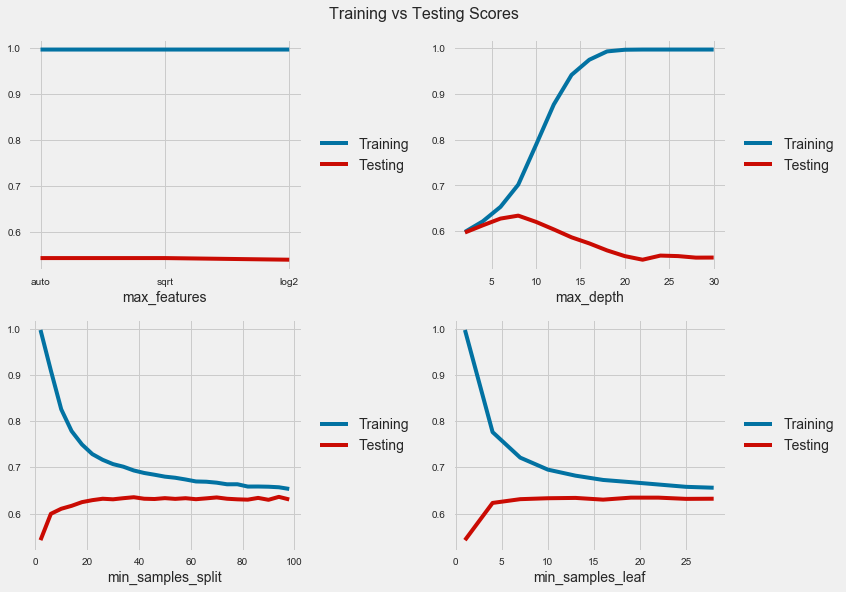

In [127]:
modf.param_tuning_plots(baseline_rforest, rforest_param_grid, X_train, y_train, gs_kwargs,
                        n_cols=2, x_axis_log_scale=False, figsize=(12,8))

From the figure above, it appears that there is not much difference on the max_features to build each tree. Since this is the case, we will got with 'sqrt' as it is empirically tested to have slightly more robust results for classification tasks.

As for max_depth for the tree to grow, it appears the optimal depth could be around 5-10 levels. 

For minimum samples to split, there does not seem to be much improvement after 20 samples. Similarly for minimum samples per leaf, there is not much improvement after 5 samples.

We will now fit a GridSearch to find the optimal hyperparamters.

In [128]:
rforest_param_grid = {
    'max_features' : ['sqrt'],
    'max_depth' : np.arange(5, 12, step=1),
    'min_samples_split' : np.arange(25, 40, step=2),
    'min_samples_leaf' : np.arange(5, 15, step=1),
}

In [129]:
rforest_gscv = GridSearchCV(baseline_rforest, rforest_param_grid, **gs_kwargs)
rforest_gscv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=8937, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_spl...
                                              oob_score=False,
                                              random_state=8888, verbose=0,
                                              warm_s

In [131]:
rforest_kwargs.update(rforest_gscv.best_params_)
rforest_kwargs

{'n_estimators': 100,
 'criterion': 'gini',
 'class_weight': 'balanced',
 'bootstrap': True,
 'n_jobs': -1,
 'random_state': 8888,
 'max_depth': 9,
 'max_features': 'sqrt',
 'min_samples_leaf': 14,
 'min_samples_split': 29}

Holdout Dataset Classification Report for Random Forest
              precision    recall  f1-score   support

           0       0.92      0.76      0.83      1033
           1       0.55      0.81      0.66       374

    accuracy                           0.77      1407
   macro avg       0.73      0.79      0.74      1407
weighted avg       0.82      0.77      0.78      1407




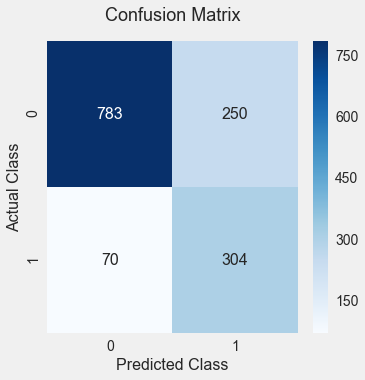

In [132]:
# Saving the best estimator during GridSearch and getting evaluating on holdout data
rforest_model = rforest_gscv.best_estimator_
rforest_y_pred = modf.holdout_evaluation(rforest_model, X_train, y_train, X_test, y_test,
                                         model_name='Random Forest', threshold=0.5)

In [133]:
rforest_results = modf.classification_scores(y_test, rforest_y_pred,
                                             model_name='RandomForest')
model_results = model_results.append(rforest_results, ignore_index=True)
model_results

,Model,Accuracy,ROC_AUC,Precision,Recall,F1
0,NearestCentroid,0.7285,0.7460,0.4933,0.7834,0.6054
1,SMOTE_NearestCentroid,0.7292,0.7482,0.4941,0.7888,0.6076
2,NearestNeighbour,0.6439,0.6944,0.4127,0.8021,0.5450
3,LogisticRegression,0.7420,0.7637,0.5092,0.8102,0.6254
4,ADASYN_LogisticRegression,0.7143,0.7508,0.4784,0.8289,0.6067
5,UntunedRForest,0.7925,0.6966,0.6434,0.4920,0.5576
6,RandomForest,0.7726,0.7854,0.5487,0.8128,0.6552


From the results table, we see that after tuning the hyper parameters, the Random Forest model performs the best.

The Random Forest's F1 Score improved by about 3% from the Logistic Regression, largely due to the higher precision. As for recall, the logistic regression remains competitive to the random forest, only 0.2% lower.

### Resampling Random Forest

In [134]:
ros_rforest_pipe = Pipeline(steps=[
    ('RandomOverSampler', ros),
    ('RandomForest', RandomForestClassifier(**rforest_kwargs))
])

smote_rforest_pipe = Pipeline(steps=[
    ('SMOTE', smote),
    ('RandomForest', RandomForestClassifier(**rforest_kwargs))
])

adasyn_rforest_pipe = Pipeline(steps=[
    ('ADASYN', adasyn),
    ('RandomForest', RandomForestClassifier(**rforest_kwargs))
])

rforest_resampled_pipes = [ros_rforest_pipe, smote_rforest_pipe, adasyn_rforest_pipe]

In [135]:
base_model_name = 'RandomForest'

for i, clf in enumerate(rforest_resampled_pipes):
    if i == 0:
        model_name = 'ROS_' + base_model_name
    if i == 1:
        model_name = 'SMOTE_' + base_model_name
    if i == 2:
        model_name = 'ADASYN_' + base_model_name
        
    cv_results = cross_validate(clf, X_train, y_train, **cv_kwargs)
    best_clf = modf.get_best_estimator(cv_results)
    y_pred = best_clf.predict(X_test)
    
    result = modf.classification_scores(y_test, y_pred, model_name)
    model_results = model_results.append(result, ignore_index=True)

In [82]:
rforest_performance = pd.concat([rforest_base, rforest_ros, rforest_smote, rforest_adasyn], axis=0)
rforest_performance

,Model,Accuracy,ROC_AUC,Precision,Recall,F1
0,RandomForest,0.746,0.774,0.514,0.834,0.636
0,ROS_RandomForest,0.733,0.761,0.499,0.821,0.621
0,SMOTE_RandomForest,0.770,0.765,0.549,0.754,0.635
0,ADASYN_RandomForest,0.762,0.763,0.537,0.765,0.631


In [136]:
model_results

,Model,Accuracy,ROC_AUC,Precision,Recall,F1
0,NearestCentroid,0.7285,0.7460,0.4933,0.7834,0.6054
1,SMOTE_NearestCentroid,0.7292,0.7482,0.4941,0.7888,0.6076
2,NearestNeighbour,0.6439,0.6944,0.4127,0.8021,0.5450
3,LogisticRegression,0.7420,0.7637,0.5092,0.8102,0.6254
4,ADASYN_LogisticRegression,0.7143,0.7508,0.4784,0.8289,0.6067
5,UntunedRForest,0.7925,0.6966,0.6434,0.4920,0.5576
6,RandomForest,0.7726,0.7854,0.5487,0.8128,0.6552
7,ROS_RandomForest,0.7733,0.7833,0.5503,0.8048,0.6536
8,SMOTE_RandomForest,0.7925,0.7640,0.5923,0.7032,0.6430
9,ADASYN_RandomForest,0.7903,0.7651,0.5872,0.7112,0.6433


From the table above, we see that the resampling has not improved the F1 score of the Random Forest model. For any gain in precision from the oversampling methods results in a much larger decrease in recall. 

In [138]:
model_results = model_results.drop([7,8,9])

In [139]:
model_results

,Model,Accuracy,ROC_AUC,Precision,Recall,F1
0,NearestCentroid,0.7285,0.7460,0.4933,0.7834,0.6054
1,SMOTE_NearestCentroid,0.7292,0.7482,0.4941,0.7888,0.6076
2,NearestNeighbour,0.6439,0.6944,0.4127,0.8021,0.5450
3,LogisticRegression,0.7420,0.7637,0.5092,0.8102,0.6254
4,ADASYN_LogisticRegression,0.7143,0.7508,0.4784,0.8289,0.6067
5,UntunedRForest,0.7925,0.6966,0.6434,0.4920,0.5576
6,RandomForest,0.7726,0.7854,0.5487,0.8128,0.6552


## Conclusion

In conclusion, the Random Forest has the best performance overall in terms of F1 score, which balances both the recall and precision.

However, it must be noted that the logistic regression model remains a competitve option as well. Furthermore, being a linear model, the logistic regression has the added benefit of easy interpretation of the results as well as being able to draw inference on how certain variables affect the log-odds of a customer churning.

Random Forests are interpretable to a certain extent, as we can use it to find out which features are important in determining whether a customer will churn.

Also, if the cost of advertisement (precision) is not a concern and the main objective is to identify as many potential churn customers, then using ADASYN resampling may be more suitable as it has around 2% higher recall than the random forest model.

In [172]:
import plotly.express as px

fig = px.bar(model_results, x='F1', y='Model', orientation='h')
fig.update_layout(
    title={
        'text' : 'F1 Scores for Different Models',
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    yaxis_title=''
)
fig.show();

In [164]:
fig = px.bar(model_results.sort_values(by='Recall', ascending=True), x='Recall', y='Model', orientation='h')
fig.update_layout(
    title={
        'text' : 'Recall Scores for Different Models',
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    yaxis_title='',
)
fig.show();

In [165]:
fig = px.bar(model_results.sort_values(by='Precision', ascending=True), x='Precision', y='Model', orientation='h')
fig.update_layout(
    title={
        'text' : 'Precision Scores for Different Models',
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    yaxis_title='',
)
fig.show();